In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [ ]:
!pip install -q transformers torch sentencepiece underthesea openpyxl tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 59.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 92.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from underthesea import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import (
    Input, Embedding, Conv2D, GlobalMaxPooling2D,
    Concatenate, Dropout, Dense, Bidirectional, GRU
)
from tensorflow.keras.models import Model

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)
import matplotlib.pyplot as plt
import itertools

In [ ]:
df_train = pd.read_csv('df_train_clean.csv')
df_dev   = pd.read_csv('df_dev_clean.csv')
df_test  = pd.read_csv('df_test_clean.csv')

In [ ]:
texts_train, y_train = df_train['content'].fillna('').tolist(), df_train['label'].tolist()
texts_dev,   y_dev   = df_dev['content'].fillna('').tolist(),   df_dev['label'].tolist()
texts_test,  y_test  = df_test['content'].fillna('').tolist(),  df_test['label'].tolist()

###Without VnEmoLex.xslx

In [ ]:
vocab_size = 20000
tok = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tok.fit_on_texts(texts_train)

In [ ]:
def to_seq(texts, maxlen):
    seq = tok.texts_to_sequences(texts)
    return pad_sequences(seq, maxlen=maxlen, padding='post', truncating='post')

In [ ]:
X_train_cnn = to_seq(texts_train, 100)
X_dev_cnn   = to_seq(texts_dev,   100)
X_test_cnn  = to_seq(texts_test,  100)

In [ ]:
X_train_gru = to_seq(texts_train, 80)
X_dev_gru   = to_seq(texts_dev,   80)
X_test_gru  = to_seq(texts_test,  80)

In [ ]:
num_classes = 3
lb = LabelBinarizer().fit(range(num_classes))
Y_train = lb.transform(y_train)
Y_dev   = lb.transform(y_dev)
Y_test  = lb.transform(y_test)

In [ ]:
from tensorflow.keras.layers import Reshape

def build_text_cnn(vocab_size, embed_dim, num_classes):
    seq_in = Input(shape=(100,), dtype='int32', name='seq_in')
    x = Embedding(vocab_size, embed_dim, input_length=100)(seq_in)

    # Reshape để phù hợp Conv2D: (batch_size, height=100, width=embed_dim, channel=1)
    x = Reshape((100, embed_dim, 1))(x)

    convs = []
    for k in (1, 2, 3, 5):
        c = Conv2D(filters=32, kernel_size=(k, embed_dim), activation='relu')(x)
        p = GlobalMaxPooling2D()(c)
        convs.append(p)

    x = Concatenate()(convs)
    x = Dropout(0.2)(x)
    out = Dense(num_classes, activation='softmax')(x)

    model = Model(seq_in, out, name='TextCNN_2D')
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
cnn = build_text_cnn(vocab_size, 100, num_classes)
cnn.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "TextCNN_2D"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ seq_in (InputLayer) │ (None, 100)       │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 100, 100)  │  2,000,000 │ seq_in[0][0]      │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 100, 100,  │          0 │ embedding[0][0]   │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 100, 1,    │      3,232 │ reshape[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 99, 1, 32) │      6,432 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 98, 1, 32) │      9,632 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 96, 1, 32) │     16,032 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 32)        │          0 │ conv2d[0][0]      │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 32)        │          0 │ conv2d_1[0][0]    │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 32)        │          0 │ conv2d_2[0][0]    │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 32)        │          0 │ conv2d_3[0][0]    │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
│                     │                   │            │ global_max_pooli… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 3)         │        387 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,035,715 (7.77 MB)

 Trainable params: 2,035,715 (7.77 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
cnn.fit(
    X_train_cnn, Y_train,
    batch_size=32, epochs=20,
    validation_data=(X_dev_cnn, Y_dev)
)

Epoch 1/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 31s 87ms/step - accuracy: 0.9850 - loss: 0.0501 - val_accuracy: 0.9128 - val_loss: 0.3462
Epoch 2/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 31s 86ms/step - accuracy: 0.9886 - loss: 0.0378 - val_accuracy: 0.9179 - val_loss: 0.3574
Epoch 3/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 31s 87ms/step - accuracy: 0.9911 - loss: 0.0327 - val_accuracy: 0.9198 - val_loss: 0.3858
Epoch 4/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 32s 90ms/step - accuracy: 0.9915 - loss: 0.0293 - val_accuracy: 0.9172 - val_loss: 0.4112
Epoch 5/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 31s 86ms/step - accuracy: 0.9908 - loss: 0.0312 - val_accuracy: 0.9172 - val_loss: 0.4308
Epoch 6/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 30s 85ms/step - accuracy: 0.9947 - loss: 0.0215 - val_accuracy: 0.9191 - val_loss: 0.4291
Epoch 7/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 31s 86ms/step - accuracy: 0.9930 - loss: 0.0223 - val_accuracy: 0.9154 - val_loss: 0.4540
Epoch 8/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 30s 85ms/step - accuracy: 0.9899 - loss: 0.0314 - 

In [ ]:
from tensorflow.keras.layers import Input, Embedding, Bidirectional, GRU, GlobalMaxPooling1D, Dense, Dropout

def build_bi_gru(vocab_size, embed_dim, num_classes):
    seq_in = Input(shape=(80,), dtype='int32', name='seq_in')
    x = Embedding(vocab_size, embed_dim, input_length=80)(seq_in)

    # Bi-GRU layer with dropout (inside GRU)
    x = Bidirectional(GRU(64, return_sequences=True, dropout=0.2))(x)

    # Max pooling after Bi-GRU
    x = GlobalMaxPooling1D()(x)

    # Dense layer of size 50 (with relu)
    x = Dense(50, activation='relu')(x)

    # Dropout after Dense
    x = Dropout(0.2)(x)

    # Output layer with softmax
    out = Dense(num_classes, activation='softmax')(x)

    model = Model(seq_in, out, name='BiGRU')
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
gru = build_bi_gru(vocab_size, 100, num_classes)
gru.summary()

Model: "BiGRU"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ seq_in (InputLayer)             │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (None, 80, 100)        │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 80, 128)        │        63,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         6,450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           153 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,070,347 (7.90 MB)

 Trainable params: 2,070,347 (7.90 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
gru.fit(
    X_train_gru, Y_train,
    batch_size=32, epochs=20,
    validation_data=(X_dev_gru, Y_dev)
)

Epoch 1/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 47s 121ms/step - accuracy: 0.7512 - loss: 0.5819 - val_accuracy: 0.9078 - val_loss: 0.2776
Epoch 2/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 42s 118ms/step - accuracy: 0.9188 - loss: 0.2521 - val_accuracy: 0.9122 - val_loss: 0.2660
Epoch 3/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 42s 118ms/step - accuracy: 0.9371 - loss: 0.2129 - val_accuracy: 0.9204 - val_loss: 0.2536
Epoch 4/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 42s 117ms/step - accuracy: 0.9466 - loss: 0.1781 - val_accuracy: 0.9210 - val_loss: 0.2459
Epoch 5/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 42s 118ms/step - accuracy: 0.9528 - loss: 0.1507 - val_accuracy: 0.9204 - val_loss: 0.2723
Epoch 6/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 42s 118ms/step - accuracy: 0.9607 - loss: 0.1262 - val_accuracy: 0.9217 - val_loss: 0.2683
Epoch 7/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 42s 118ms/step - accuracy: 0.9680 - loss: 0.1078 - val_accuracy: 0.9090 - val_loss: 0.3008
Epoch 8/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 42s 118ms/step - accuracy: 0.9726 - loss: 0

In [ ]:
def eval_and_report(model, X_seq, y_true, name):
    y_pred_prob = model.predict(X_seq, verbose=0)
    y_pred      = y_pred_prob.argmax(axis=1)
    acc     = accuracy_score(y_true, y_pred)
    p_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
    r_macro = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f_micro = f1_score(y_true, y_pred, average='micro')
    f_macro = f1_score(y_true, y_pred, average='macro')
    print(f"\n--- {name} on Test ---")
    print(f"Accuracy       : {acc:.4f}")
    print(f"Precision-Macro: {p_macro:.4f}")
    print(f"Recall-Macro   : {r_macro:.4f}")
    print(f"F1-Micro       : {f_micro:.4f}")
    print(f"F1-Macro       : {f_macro:.4f}\n")
    print(classification_report(y_true, y_pred, digits=4))
    labels = [0,1,2]
    ticks  = ['neg','neu','pos']
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(5,4))
    cmap = plt.cm.Blues
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(f"{name} Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, ticks, rotation=45)
    plt.yticks(tick_marks, ticks)
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > thresh else "black"
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center", color=color)

    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()


--- Text-CNN on Test ---
Accuracy       : 0.8860
Precision-Macro: 0.7787
Recall-Macro   : 0.7377
F1-Micro       : 0.8860
F1-Macro       : 0.7536

              precision    recall  f1-score   support

           0     0.8816    0.9297    0.9050      1409
           1     0.5378    0.3832    0.4476       167
           2     0.9167    0.9000    0.9083      1590

    accuracy                         0.8860      3166
   macro avg     0.7787    0.7377    0.7536      3166
weighted avg     0.8811    0.8860    0.8825      3166



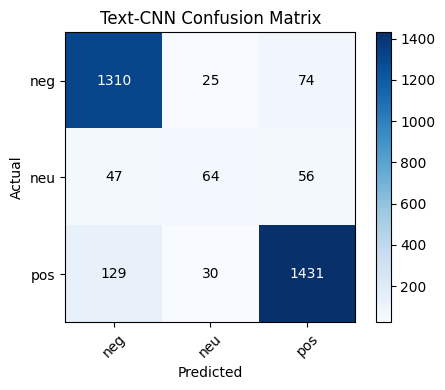

In [ ]:
eval_and_report(cnn, X_test_cnn, y_test, 'Text-CNN')


--- Bi-GRU on Test ---
Accuracy       : 0.9021
Precision-Macro: 0.7977
Recall-Macro   : 0.7422
F1-Micro       : 0.9021
F1-Macro       : 0.7617

              precision    recall  f1-score   support

           0     0.8862    0.9560    0.9198      1409
           1     0.5660    0.3593    0.4396       167
           2     0.9409    0.9113    0.9259      1590

    accuracy                         0.9021      3166
   macro avg     0.7977    0.7422    0.7617      3166
weighted avg     0.8968    0.9021    0.8975      3166



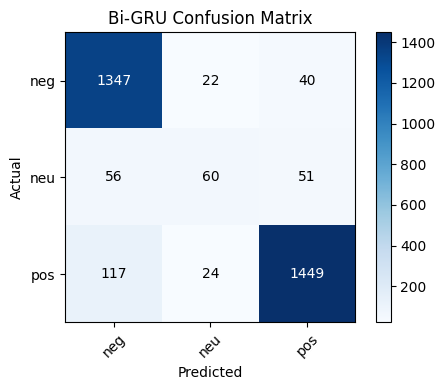

In [ ]:
eval_and_report(gru, X_test_gru, y_test, 'Bi-GRU')

###With VnEmoLex.xslx

In [ ]:
emo_df = pd.read_excel('VnEmoLex.xlsx', sheet_name=0)
words    = emo_df['Vietnamese'].astype(str)
pos_flag = emo_df['Positive'].fillna(0).astype(int)
neg_flag = emo_df['Negative'].fillna(0).astype(int)

In [ ]:
lex_dict = {
    0: set(words[neg_flag==1]),
    1: set(words[(pos_flag==0)&(neg_flag==0)]),
    2: set(words[pos_flag==1])
}

In [ ]:
print(f"Lexicon sizes: neg={len(lex_dict[0])}, neu={len(lex_dict[1])}, pos={len(lex_dict[2])}")

Lexicon sizes: neg=2895, neu=5261, pos=2524


In [ ]:
def lex_features(texts, lexicon_dict=lex_dict):
    feats = []
    labels = sorted(lexicon_dict.keys())  # [0,1,2]
    for t in texts:
        toks = word_tokenize(t, format="text").split()
        counts = [sum(1 for w in toks if w in lexicon_dict[l]) for l in labels]
        feats.append(counts)
    return np.array(feats, dtype='float32')

In [ ]:
LX_train = lex_features(texts_train)
LX_dev   = lex_features(texts_dev)
LX_test  = lex_features(texts_test)

In [ ]:
vocab_size = 20000
tok = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tok.fit_on_texts(texts_train)

In [ ]:
def to_seq(texts, maxlen):
    seq = tok.texts_to_sequences(texts)
    return pad_sequences(seq, maxlen=maxlen, padding='post', truncating='post')

In [ ]:
X_train_cnn = to_seq(texts_train, 100)
X_dev_cnn   = to_seq(texts_dev,   100)
X_test_cnn  = to_seq(texts_test,  100)

In [ ]:
X_train_gru = to_seq(texts_train, 80)
X_dev_gru   = to_seq(texts_dev,   80)
X_test_gru  = to_seq(texts_test,  80)

In [ ]:
num_classes = 3
lb = LabelBinarizer().fit(range(num_classes))
Y_train = lb.transform(y_train)
Y_dev   = lb.transform(y_dev)
Y_test  = lb.transform(y_test)

In [ ]:
for name, arr in [
    ("X_train_cnn", X_train_cnn), ("LX_train", LX_train), ("Y_train", Y_train),
    ("X_dev_cnn",   X_dev_cnn),   ("LX_dev",   LX_dev),   ("Y_dev",   Y_dev)
]:
    print(f"{name:12s} | {arr.dtype}, shape={arr.shape}")


X_train_cnn  | int32, shape=(11426, 100)
LX_train     | float32, shape=(11426, 3)
Y_train      | int64, shape=(11426, 3)
X_dev_cnn    | int32, shape=(1583, 100)
LX_dev       | float32, shape=(1583, 3)
Y_dev        | int64, shape=(1583, 3)


In [ ]:
def build_text_cnn(vocab_size, embed_dim, num_classes):
    seq_in = Input(shape=(100,), dtype='int32', name='seq_in')
    lex_in = Input(shape=(3,), dtype='float32', name='lex_in')

    x = Embedding(vocab_size, embed_dim, input_length=100)(seq_in)
    x = Reshape((100, embed_dim, 1))(x)

    convs = []
    for k in (1, 2, 3, 5):
        c = Conv2D(filters=32, kernel_size=(k, embed_dim), activation='relu')(x)
        p = GlobalMaxPooling2D()(c)
        convs.append(p)

    x = Concatenate()(convs)
    x = Dropout(0.2)(x)

    x = Concatenate()([x, lex_in])

    out = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=[seq_in, lex_in], outputs=out, name='TextCNN_with_lexicon')
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
cnn = build_text_cnn(vocab_size, 100, num_classes)
cnn.summary()

Model: "TextCNN_with_lexicon"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ seq_in (InputLayer) │ (None, 100)       │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 100, 100)  │  2,000,000 │ seq_in[0][0]      │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 100, 100,  │          0 │ embedding_4[0][0] │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 100, 1,    │      3,232 │ reshape_2[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 99, 1, 32) │      6,432 │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 98, 1, 32) │      9,632 │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 96, 1, 32) │     16,032 │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 32)        │          0 │ conv2d_8[0][0]    │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 32)        │          0 │ conv2d_9[0][0]    │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 32)        │          0 │ conv2d_10[0][0]   │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 32)        │          0 │ conv2d_11[0][0]   │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 128)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
│                     │                   │            │ global_max_pooli… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lex_in (InputLayer) │ (None, 3)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 131)       │          0 │ dropout_3[0][0],  │
│ (Concatenate)       │                   │            │ lex_in[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 3)         │        396 │ concatenate_3[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,035,724 (7.77 MB)

 Trainable params: 2,035,724 (7.77 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
cnn.fit(
    [X_train_cnn, LX_train], Y_train,
    batch_size=32,
    epochs=20,
    validation_data=([X_dev_cnn, LX_dev], Y_dev)
)

Epoch 1/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 34s 89ms/step - accuracy: 0.7432 - loss: 0.5986 - val_accuracy: 0.9021 - val_loss: 0.2793
Epoch 2/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 31s 87ms/step - accuracy: 0.9159 - loss: 0.2542 - val_accuracy: 0.9204 - val_loss: 0.2488
Epoch 3/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 30s 85ms/step - accuracy: 0.9337 - loss: 0.1947 - val_accuracy: 0.9229 - val_loss: 0.2472
Epoch 4/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 30s 84ms/step - accuracy: 0.9550 - loss: 0.1498 - val_accuracy: 0.9255 - val_loss: 0.2485
Epoch 5/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 30s 85ms/step - accuracy: 0.9559 - loss: 0.1367 - val_accuracy: 0.9229 - val_loss: 0.2610
Epoch 6/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 30s 85ms/step - accuracy: 0.9659 - loss: 0.1077 - val_accuracy: 0.9255 - val_loss: 0.2765
Epoch 7/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 30s 85ms/step - accuracy: 0.9688 - loss: 0.0972 - val_accuracy: 0.9217 - val_loss: 0.3024
Epoch 8/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 30s 85ms/step - accuracy: 0.9743 - loss: 0.0840 - 

In [ ]:
from tensorflow.keras.layers import Input, Embedding, Bidirectional, GRU, GlobalMaxPooling1D, Dense, Dropout

def build_bi_gru(vocab_size, embed_dim, num_classes):
    seq_in = Input(shape=(80,), dtype='int32', name='seq_in')
    lex_in = Input(shape=(3,), dtype='float32', name='lex_in')

    # Embedding + BiGRU
    x = Embedding(vocab_size, embed_dim, input_length=80)(seq_in)
    x = Bidirectional(GRU(64, return_sequences=True, dropout=0.2))(x)
    x = GlobalMaxPooling1D()(x)

    # Dense + Dropout
    x = Dense(50, activation='relu')(x)
    x = Dropout(0.2)(x)

    # Kết hợp với lexicon
    x = Concatenate()([x, lex_in])

    out = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=[seq_in, lex_in], outputs=out, name='BiGRU_with_lexicon')
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
gru = build_bi_gru(vocab_size, 100, num_classes)
gru.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "BiGRU_with_lexicon"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ seq_in (InputLayer) │ (None, 80)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 80, 100)   │  2,000,000 │ seq_in[0][0]      │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 80, 128)   │     63,744 │ embedding_1[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ bidirectional_1[… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 50)        │      6,450 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 50)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lex_in (InputLayer) │ (None, 3)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 53)        │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ lex_in[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 3)         │        162 │ concatenate[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,070,356 (7.90 MB)

 Trainable params: 2,070,356 (7.90 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
gru.fit(
    [X_train_gru, LX_train], Y_train,
    batch_size=32,
    epochs=20,
    validation_data=([X_dev_gru, LX_dev], Y_dev)
)

Epoch 1/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 57s 144ms/step - accuracy: 0.7147 - loss: 0.6535 - val_accuracy: 0.9040 - val_loss: 0.2825
Epoch 2/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 81s 141ms/step - accuracy: 0.9121 - loss: 0.2661 - val_accuracy: 0.9160 - val_loss: 0.2592
Epoch 3/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 82s 141ms/step - accuracy: 0.9316 - loss: 0.2144 - val_accuracy: 0.9242 - val_loss: 0.2430
Epoch 4/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 82s 141ms/step - accuracy: 0.9452 - loss: 0.1722 - val_accuracy: 0.9242 - val_loss: 0.2540
Epoch 5/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 82s 141ms/step - accuracy: 0.9530 - loss: 0.1507 - val_accuracy: 0.9267 - val_loss: 0.2818
Epoch 6/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 83s 143ms/step - accuracy: 0.9590 - loss: 0.1292 - val_accuracy: 0.9229 - val_loss: 0.2612
Epoch 7/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 81s 140ms/step - accuracy: 0.9640 - loss: 0.1156 - val_accuracy: 0.9292 - val_loss: 0.2944
Epoch 8/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 82s 141ms/step - accuracy: 0.9705 - loss: 0

In [ ]:
def eval_and_report(model, X_seq, LX, y_true, name):
    y_pred_prob = model.predict([X_seq, LX], verbose=0)
    y_pred      = y_pred_prob.argmax(axis=1)
    acc     = accuracy_score(y_true, y_pred)
    p_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
    r_macro = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f_micro = f1_score(y_true, y_pred, average='micro')
    f_macro = f1_score(y_true, y_pred, average='macro')
    print(f"\n--- {name} on Test ---")
    print(f"Accuracy       : {acc:.4f}")
    print(f"Precision-Macro: {p_macro:.4f}")
    print(f"Recall-Macro   : {r_macro:.4f}")
    print(f"F1-Micro       : {f_micro:.4f}")
    print(f"F1-Macro       : {f_macro:.4f}\n")
    print(classification_report(y_true, y_pred, digits=4))
    labels = [0,1,2]
    ticks  = ['neg','neu','pos']
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(5,4))
    cmap = plt.cm.Blues
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(f"{name} Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, ticks, rotation=45)
    plt.yticks(tick_marks, ticks)
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > thresh else "black"
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center", color=color)

    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()


--- Text-CNN+VnEmoLex on Test ---
Accuracy       : 0.9002
Precision-Macro: 0.8054
Recall-Macro   : 0.7438
F1-Micro       : 0.9002
F1-Macro       : 0.7658

              precision    recall  f1-score   support

           0     0.9003    0.9361    0.9179      1409
           1     0.5962    0.3713    0.4576       167
           2     0.9198    0.9239    0.9219      1590

    accuracy                         0.9002      3166
   macro avg     0.8054    0.7438    0.7658      3166
weighted avg     0.8941    0.9002    0.8956      3166



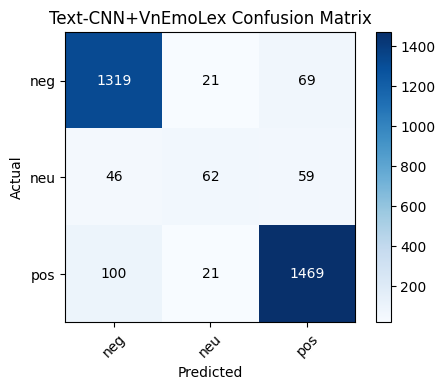

In [ ]:
eval_and_report(cnn, X_test_cnn, LX_test, y_test, 'Text-CNN+VnEmoLex')


--- Bi-GRU+VnEmoLex on Test ---
Accuracy       : 0.9024
Precision-Macro: 0.7924
Recall-Macro   : 0.7578
F1-Micro       : 0.9024
F1-Macro       : 0.7721

              precision    recall  f1-score   support

           0     0.9060    0.9375    0.9215      1409
           1     0.5433    0.4132    0.4694       167
           2     0.9279    0.9226    0.9253      1590

    accuracy                         0.9024      3166
   macro avg     0.7924    0.7578    0.7721      3166
weighted avg     0.8979    0.9024    0.8995      3166



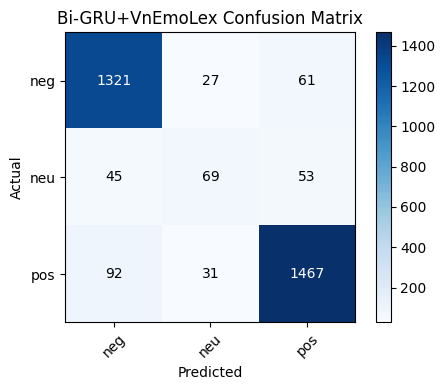

In [ ]:
eval_and_report(gru, X_test_gru, LX_test, y_test, 'Bi-GRU+VnEmoLex')